### 목적
- 에이전트의 메시지 상태(AgentState)를 통해 단기 메모리 관리
- LLM 호출 전후의 흐름(모델/툴 실행 등)을 AgentMiddleware 훅으로 제어, 감시하는 구조 설계

In [15]:
import os, json
from dotenv import load_dotenv

from langchain.agents import create_agent
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents.structured_output import ToolStrategy
from langchain.agents import AgentState
# AgentState: 에이전트 상태를 정의한 TypedDict 스키마 
# -> LangGraph기반 ReAct 에이전트가 루프를 돌 때 메시지 기록 등 단기 메모리(런타임 상태)를 담는 표준 형태
from langchain.agents.middleware import AgentMiddleware
# AgentMiddleware: 에이전트가 LLM을 호출하거나 툴을 실행하는 지점을 가로채서, 
# 사전/사후 처리, 검증, 로깅, 재시도, 단축 종료같은 공통 로직을 주입하는 미들웨어 추상 클래스
from langchain.agents.middleware import ModelRequest, ModelResponse

load_dotenv()

True

In [16]:
@tool
def tool1():
    """
    description1
    """
    return

@tool
def tool2():
    """
    description2
    """
    return

#### 라이프 사이클
1. [before_agent] 에이전트 시작 직전 1회
2. [before_model] 매 LLM 호출 직전
4. [wrap_model_call] 모델 호출 자체를 감싸서 재시도/타임아웃/폴백 등
5. [모델 호출]
6. [after_model] LLM 응답 직후 검증/정제/상태업데이트
7. [wrap_tool_call] 각 툴 실행을 감싸서 권한/로깅/리트라이
8. [after_agent] 에이전트 종료 직후 1회(정리/메트릭 전송)

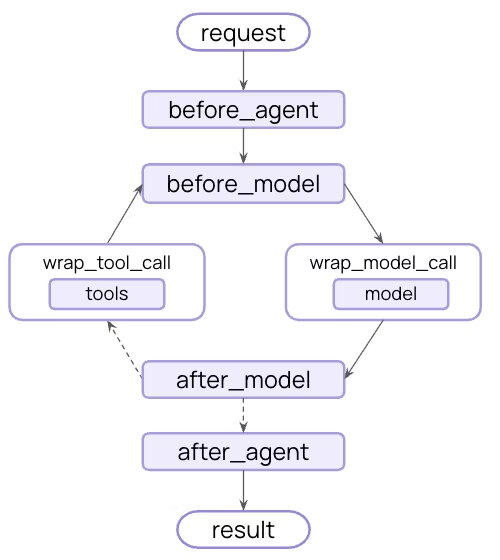

In [17]:
# 미들웨어를 통한 상태 정의
class CustomState(AgentState):
    user_preferences: dict

class CustomMiddleware(AgentMiddleware):
    state_schema = CustomState
    tools = [tool1, tool2] # 미들웨어에서 사용할 툴 지정
    # LangChain은 AgentMiddleware가 들고있는 tools를 자동으로 에이전트에 등록한다.
    # create_agent()에서 별도로 추가하지 않아도 된다.

    # CustomMiddleware 내부에서 오버라이드하는 훅의 종류
    # 전부 필수 구현할 필요는 없음 -> 필요에 따라 구현
    def before_agent(self, state, runtime):
        # 1회 실행: 입력 검증, 세션 초기화 등
        return None

    def before_model(self, state, runtime):
        # LLM 호출 직전: 프롬프트/메시지 트리밍, 시스템 프롬프트 주입 등
        return None

    def wrap_model_call(self, request, handler):
        # 재시도/타임아웃/HITL 승인 등 공통 로직
        return handler(request)  # 필요 시 try/except로 감싸기

    def wrap_tool_call(self, request, handler):
        # 권한 체크/로깅/리트라이
        return handler(request)

    def after_model(self, state, runtime):
        # 출력 검증/정규화/상태 업데이트
        return None

    def after_agent(self, state, runtime):
        # 로그/결과 저장/클린업
        return None

In [18]:
llm = ChatOpenAI(
    model='gpt-4o-mini',
    api_key=os.getenv("OPENAI_API_KEY")
)

agent = create_agent(
    model=llm,
    tools=[],
    middleware=[CustomMiddleware()]
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "나는 기술적인 설명을 선호한다."}],
    "user_preferences": {"style": "technical", "verbosity": "detailed"},
})

print(result.get("messages")[-1].content)

알겠습니다. 기술적인 설명을 선호하신다면, 필요한 주제나 질문에 대해 구체적인 설명을 제공하겠습니다. 어떤 주제에 대해 이야기하고 싶으신가요?


#### AgentMiddleware가 데코레이터 방식보다 좋은 점
- 에이전트 전반 여러 단계를 하나에 묶어서 다룬다.
- state_schema를 지정하여 상태를 기억할 수 있다.

#### 미들웨어 사용처
- AgentMiddleware: 상태 기반 정책의 일관성이 중요한 경우
- 데코레이터 방식: "이번 호출만 파라미터 조정"같은 국지적 변경이 있는 경우

#### 추가 설명
- AgentMiddleware도 middleware=[aw1(), aw2()]처럼 여러 개 사용할 수 있다. -> 순서 중요
- 미들웨어에 훅을 사용하지 않고 상태 필드만 추가한다면 create_agent에 middleware=[my_middleware()] 대신 state_schema=my_state만 지정해도 된다.